<h1><center> Corrección distorsión de barril </center></h1>

### Integrantes Equipo 7


Albert Marquillas Estruch  
Eduardo Reyero Ibáñez  
Jerónimo Cabezuelo Ruiz  
Salvador Florido Llorens 

### Asistencia a las reuniones de los integrantes del grupo

<table class="default">
    <thead>
    <tr>
        <th style="text-align:center;color:#0000FF">Alumnos</th>
        <th style="text-align:center;color:#0000FF">Asistencia a Reuniones</th>
        <th style="text-align:center;color:#0000FF">Trabajo aportado</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td style="text-align:left"> Albert Marquillas Estruch </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    <tr>
        <td style="text-align:left"> Eduardo Reyero Ibáñez </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    <tr>
        <td style="text-align:left"> Jerónimo Cabezuelo Ruiz </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    <tr>
        <td style="text-align:left"> Salvador Florido LLorens </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    </tbody>
</table>

### 1. Descripción del problema

La anomalía que se desea corregir en este trabajo se denomina "distorsión de barril", la cual, se produce por ciertas características de la lente. Concretamente, se produce cuando trabajamos con distancias focales cortas (inferiores a 35 mm), y utilizamos objetivos angulares. En esta anomalía, las líneas de los extremos de la imagen se abomban hacia los laterales. Esta distorsión afecta en mayor medida a los bordes de la imagen, siendo la parte central la que queda menos afectada [1].

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Barrel_distortion.svg/100px-Barrel_distortion.svg.png"  align="center"/>

### 2. Imágenes de ejemplo

Para esta actividad se ha decidido seleccionar un total de tres imagenes de ejemplo, dos de ellas representan ejemplos genéricos con un artefacto apreciable, y la tercera imagen es un ejemplo con un artefacto del mismo tipo pero de mayor nivel. Este servirá para poder ver hasta que punto funciona bien la correción planteada.

In [1]:
import numpy as np
from skimage import io
import math
import matplotlib.pyplot as plt

#### Imagen de un bosque:

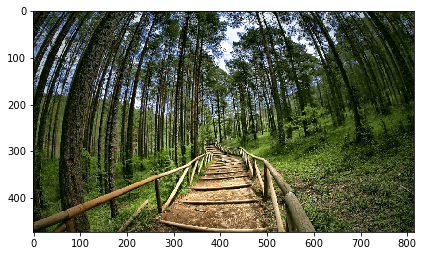

In [2]:
img_forest = (io.imread('forest.png'))[:,:,0:3]
io.imshow(img_forest)

#### Imagen desde una ventana:

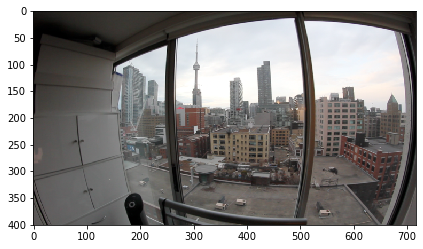

In [3]:
img_window = (io.imread('window.png'))[:,:,0:3]
io.imshow(img_window)

#### Imagen de un edificio

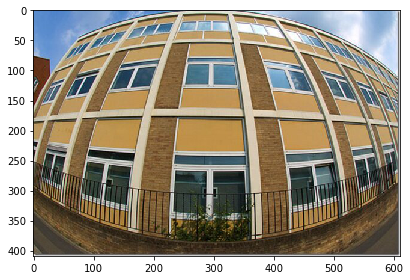

In [4]:
img_building = (io.imread('building.jpg'))[:,:,0:3]
io.imshow(img_building)

### 3. Solución propuesta

Para solucionar el artefacto de efecto barril se ha propuesto una funcion en python con un operador punto a punto, en la que para cada pixel de la imagen, se recoloca cada pixel a su posicion real. La forma en la que se realiza esta operacion es partiendo de la circunferencia que marca la distorsión, los pixeles son trasladados a su nueva posición, que se calcula a partir de una ecuación polinómica de tercer grado marcada por los coeficientes a, b y c [2], donde el valor de a tiene un control general, b tiene un control uniforme sobre la imagen y c tiene control en la parte central de la imagen.

Para la creación de este algoritmo se ha utilizado un algoritmo en codigo en lenguaje C [3] como referéncia. Este ha sido traducido a Python, y se ha intentado optimizar el máximo sacando cálculos genéricos del bucle.

In [5]:
def correccion(imagen,a=0.035,b=0.035,c=0.035):
    """
    Funcion de correcion del efecto barril en las imagenes, como argumento imprescindible esta la imagen, 
    y luego los factores a, b y c sirven para ajustar mejor la correcion realizada per el programa, los tres
    tienen como valor por defecto el de 0.035
    imagen: imagen original
    Los parametros a,b,c controlan el efecto:
    a: Control general
    b: Control mas uniforme.
    c: Controla sobre todo al parte mas central de la imagen.
    """
    #---------- Paso 1: Cálculo de parámetros básicos de la imagen -------------------
    #Creamos una imagen con las mismas dimensiones con todo ceros
    new_image = np.zeros(imagen.shape,dtype=np.uint8)
    #Calculamos el alto y el ancho de la imagen original
    width = imagen.shape[0]
    heigth = imagen.shape[1]
    #Calculamos el radio del circulo.
    circle_rad=min([width,heigth])/2
    #Calculamos el centro de la imagen.
    center_x=(width-1)/2
    center_y=(heigth-1)/2
    #El parametro d es para que los pixeles que estan en el circulo vayan a parar al mismo circulo
    d=1.0-a-b-c
    
    #Recorremos todos los pixeles
    for x in range(width):
        for y in range(heigth):
            
            #---------- Paso 2: Cálculo de las coordenadas polares -------------------
            #Vamos a calcular que pixel de la imagen original vamos a poner en este pixel:
            #Calculamos la coordenada polar ro de este pixel normalizada con el radio del circulo
            delta_x=(x-center_x)/circle_rad
            delta_y=(y-center_y)/circle_rad
            distance_R = math.sqrt(delta_x**2+delta_y**2)
            #A esta coordenada polar le vamos a hacer la transformacion 1/p(ro)
            #donde p(x) = ax^3 +bx^2+cx+d
            src_R = (a * distance_R*distance_R*distance_R + b * distance_R*distance_R + c * distance_R + d)
            #Tenemos que tener cuidado cuando f(ro)=0
            #porque al poder 1/f(ro), estaremos dividiendo entre 0
            if src_R != 0:
                #---------- Paso 3: Cálculo del factor -------------------
                #Calculamos el factor
                factor = abs(1/src_R)
                
                #---------- Paso 4: Cálculo de las nuevas coordenadas cartesianas de la imagen -------------
                #Calculamos las coordenadas del pixel que vamos a mover utilizando el factor
                srcXd = center_x + (delta_x * factor * circle_rad)
                srcYd = center_y + (delta_y * factor * circle_rad)
                #Redondeamos estos pixeles que en principio no son enteros 
                srcX = int(srcXd)
                srcY = int(srcYd)
                
                #----- Paso 5: Asignación de los pixeles de la imagen original a las nuevas coordenadas ----------
                #El pixel que vamos a utilizar tiene que estar dentro de la imagen original
                if srcX >= 0 and srcY >= 0 and srcX < width and srcY < heigth:
                    new_image[x,y] = imagen[srcX,srcY]      
            else:
                
                #----- Paso 5: Asignación de los pixeles de la imagen original a las nuevas coordenadas ------
                new_image[x,y] = imagen[x,y]
                   
                    
    #Devolvemos la imagen que hemos creado
    return new_image

### 4. Correcciones

En este apartado se van a mostrar las distintas correcciones para cada una de las imagenes, donde para cada una de ellas se va a mostrar el resultado de aplicar el algoritmo, y a su lado, se va a poder ver la imagen original.

Para cada imagen, se hará una breve descripción del resultado y como se han utilizado los parámetros para mejorar el resultado.

In [12]:
# Función para imprimir las dos imagenes juntas y comparar
def imshow_compare(img,img_transform):
    fig = plt.figure(figsize = (14,14))
    ax0 = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    # Original image
    ax0.imshow(img,cmap=plt.cm.gray)
    ax0.set_xticks([]), ax0.set_yticks([])
    ax0.set_title('Imagen original')
    # Transformed image
    ax1.imshow(img_transform,cmap=plt.cm.gray)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title('Imagen transformada')
    #Plot
    plt.show()

#### Imagen de un bosque:

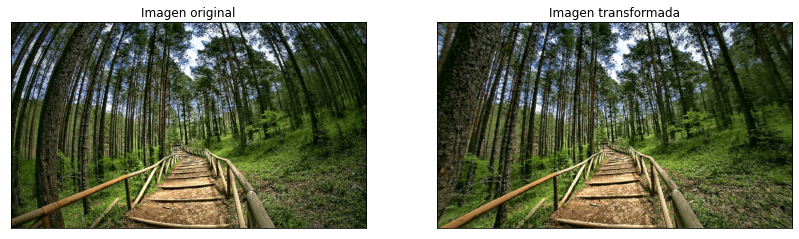

In [13]:
img_forest_corretion = correccion(img_forest)
imshow_compare(img_forest, img_forest_corretion)
io.imsave("forest_corretion.jpg",img_forest_corretion)

En esta primera imagen de ejemplo, la cual tenia un artefacto notable, se obtiene un resultado muy favorable, viendo como todos los árbloes se ven completamente rectos, aunque esta conversion ha significado perder cierta parte del exterior de la imagen.

#### Imagen desde una ventana:

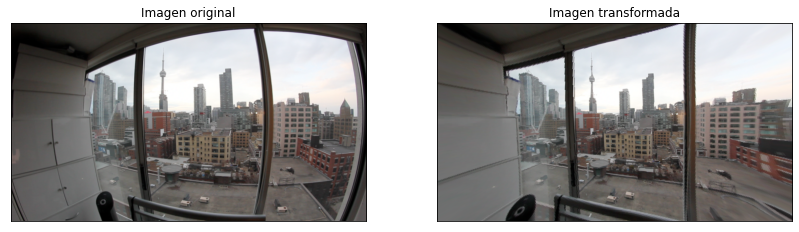

In [14]:
b = 0.075
img_window_corretion = correccion(img_window,b = b)
imshow_compare(img_window, img_window_corretion)
io.imsave("window_corretion.jpg",img_window_corretion)

Para esta segunda imagen, el resultado de aplicar el algoritmo ha sido igualmente favorable, pero también ha sufrido el problema de los bordes recortados. En este caso, ha sido necesario ajustar el valor de b a un valor mayor para ejercer una mejor corrección, ya que con los valores por defecto aún se podía apreciar el artefacto.

#### Imagen de un edificio

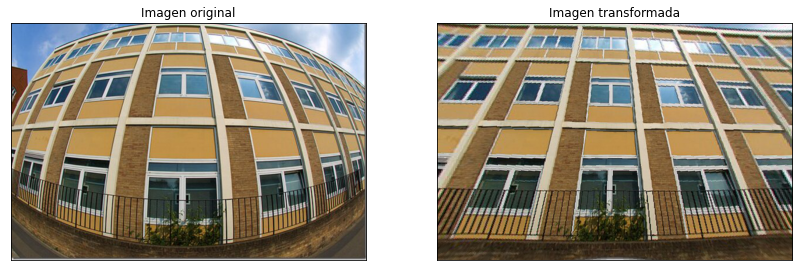

In [15]:
a = 0.0215
b = 0.025
c = 0.22
img_building_corretion = correccion(img_building,a,b,c)
imshow_compare(img_building, img_building_corretion)
io.imsave("building_corretion.jpg",img_building_corretion)

Esta última imagen de ejemplo, que es la que tenía el artefacto más marcado, ha mejorado mucho respecto la imagen original, pero aún así en las zonas más cercanas a los bordes sigue habiendo cierta deformación. Esta imagen también ha sufrido cierto recorte en las partes más exteriores. En este caso, para corregir la imagen y obtener el mejor resultado, se han tenido que utilizar los tres parámetros de ajuste.

Observando los distintos resultados, se puede concluir que la solución propuesta funciona de forma correcta, aunque esta corte parte de los bordes. Para que el algoritmo tenga los mejores resultados lo mejor es utilizar los distintos valores de a, b y c correspondientes a la camara con la que se ha sacado la foto, aunque sin ellos el algoritmo también es capaz de devolver una imagen corregida.

### 5. Bibliografía:

[1] https://foto321.com/blog/tutpriales/que-es-la-distorsion-barril-y-de-cojin/  
[2] https://mipav.cit.nih.gov/pubwiki/index.php/Barrel_Distortion_Correction  
[3] https://stackoverrun.com/es/q/3388100 